# Marked Gender in Human Category Systems

In [1]:
import re
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np
import latextable as lt
import texttable as tt
from Code import process_lcsh
from Code import marking_gender as gm
from Code import plots

import warnings
warnings.filterwarnings('ignore')

## LCSH

### Load Data


In [2]:
fp = os.path.join(os.path.abspath('Data/LCSH'))
gendered_lcsh = process_lcsh.csv_to_dict(f'{fp}/lcsh-topics.csv', True)
lcsh_m, lcsh_w, lcsh_a = gm.split_into_gendered(gendered_lcsh)
total = len(lcsh_m) + len(lcsh_w)


deprecated_gendered = process_lcsh.csv_to_dict(f'{fp}/lcsh-topics-deprecated.csv', True)
deprecated_m, deprecated_w, deprecated_a = gm.split_into_gendered(deprecated_gendered)
total_deprecated = len(deprecated_m) + len(deprecated_w)

print(f'There are {total+len(lcsh_a):,} LCSH headings in total. {len(lcsh_a):,} are ambiguous.')

There are 2,876 LCSH headings in total. 4 are ambiguous.


I focus on the headings that are tagged as referring to either Women or Men, not both. 

In [3]:
table1 = tt.Texttable()
table1.set_deco(tt.Texttable.HEADER)
table1.set_cols_align(['l'] + ['c']*3)
table1.set_cols_valign(['m']*4)
table1.add_rows([['', 'Men', 'Women', 'Total'], 
                 ['Total', len(lcsh_m)+len(deprecated_m), len(lcsh_w)+len(deprecated_w), total+total_deprecated],
                 ['Deprecated', len(deprecated_m), len(deprecated_w), total_deprecated], 
                 ['In Use', len(lcsh_m), len(lcsh_w), total] 
                 ])
table = lt.draw_latex(table1, caption='Number of gendered headings in the LCSH retrieved using the list of key words in \hyperref[tab:gendered-words]{Table 1}.', label='tab:term-counts', use_booktabs=True, caption_above=True)
print(table1.draw())
with open('Outputs/Tables/table1.tex', 'w') as f:
    f.write(table)

             Men   Women   Total
Total        383   2500    2883 
Deprecated    2      9      11  
In Use       381   2491    2872 


### Split into Cases
Made up of different combinations of W, M, and G. Each letters being present in a case means...
- W: a heading for women exists in the LCSH (i.e. women caregivers)
- M: a heading for men exists the LCSH (i.e. male caregivers)
- G: a generic parent heading exists in the LCSH (i.e. caregivers)

In [4]:
concept_pairs = gm.get_concept_idxs(lcsh_m, lcsh_w, 'heading')
total_concepts = len(concept_pairs)
categories = gm.split_into_categories(concept_pairs, gendered_lcsh, 'heading')

wmg = [(categories['w'][i], categories['m'][i], categories['g'][i] ) for i in range(total_concepts) if categories['mInLCSH'][i] == 1 and categories['wInLCSH'][i] == 1 and categories['gInLCSH'][i] == 1]
wm = [(categories['w'][i], categories['m'][i]) for i in range(total_concepts) if categories['mInLCSH'][i] == 1 and categories['wInLCSH'][i] == 1 and categories['gInLCSH'][i] == 0]
wg = [(categories['w'][i], categories['g'][i]) for i in range(total_concepts) if categories['mInLCSH'][i] == 0 and categories['wInLCSH'][i] == 1 and categories['gInLCSH'][i] == 1]
mg = [(categories['m'][i], categories['g'][i]) for i in range(total_concepts) if categories['mInLCSH'][i] == 1 and categories['wInLCSH'][i] == 0 and categories['gInLCSH'][i] == 1]
w = [(categories['w'][i],) for i in range(total_concepts) if categories['mInLCSH'][i] == 0 and categories['wInLCSH'][i] == 1 and categories['gInLCSH'][i] == 0]
m = [(categories['m'][i],) for i in range(total_concepts) if categories['mInLCSH'][i] == 1 and categories['wInLCSH'][i] == 0 and categories['gInLCSH'][i] == 0]


table3 = tt.Texttable()
table3.set_deco(tt.Texttable.HEADER)
table3.set_cols_align(['r', 'l'])
table3.add_rows([['Cases', 'Counts'],
                 ['WMG', len(wmg)],
                 ['WM', len(wm)],
                 ['WG', len(wg)],
                 ['MG', len(mg)],
                 ['W', len(w)],
                 ['M', len(m)],
                 ['Total', total_concepts]
                ])
table = lt.draw_latex(table3, caption='Marked cases and their frequencies in the LCSH.', label='tab:markedness', use_booktabs=True, caption_above=True)
print(table3.draw())
with open('Outputs/Tables/table2.tex', 'w') as f:
    f.write(table)

Cases   Counts
  WMG   120   
   WM   78    
   WG   1660  
   MG   88    
    W   633   
    M   95    
Total   2674  


Save each group of headings to a separate text file

In [5]:
with open('Outputs/Category Lists/lcsh-wmg.txt', 'w') as f:
    for triplet in wmg:
        f.write(f'{triplet[0]};\t{triplet[1]};\t{triplet[2]}\n')
with open('Outputs/Category Lists/lcsh-wm.txt', 'w') as f:
    for pair in wm:
        f.write(f'{pair[0]};\t{pair[1]}\n')
with open('Outputs/Category Lists/lcsh-wg.txt', 'w') as f:
    for pair in wg:
        f.write(f'{pair[0]};\t{pair[1]}\n')
with open('Outputs/Category Lists/lcsh-mg.txt', 'w') as f:
    for pair in mg:
        f.write(f'{pair[0]};\t{pair[1]}\n')
with open('Outputs/Category Lists/lcsh-w.txt', 'w') as f:
    for item in w:
        f.write(f'{item[0]}\n')
with open('Outputs/Category Lists/lcsh-m.txt', 'w') as f:
    for item in m:
        f.write(f'{item[0]}\n')

### Gender Asymmetry: 
The number of unpaired terms for women (w + wg) versus the number of unpaired terms for men (m + mg)

In [6]:
w_unbalanced = len(wg) + len(w)
m_unablanced = len(mg) + len(m)
total_unbalanced = w_unbalanced + m_unablanced

table4 = tt.Texttable()
table4.set_deco(tt.Texttable.HEADER)
table4.set_cols_align(['l', 'l'])
table4.add_rows([['', '%'],
                 ['Women', f'{w_unbalanced/total_unbalanced:.2%}'],
                 ['Men', f'{m_unablanced/total_unbalanced:.2%}']
                ])

print('')
table = lt.draw_latex(table4, caption='Gender assymetry.', label='tab:markedness', use_booktabs=True, caption_above=True)
print(table4.draw())
with open('Outputs/Tables/table3.tex', 'w') as f:
    f.write(table)


          %   
Women   92.61%
Men     7.39% 


### Gender Markedness: 
A concept is marked by gender if a gendered subcategory exists for one gender but not the other. Therefore I specifically look at the cases where a generic parent category exists in the LCSH but only one gendered subcategory exists (WG vs MG)

In [7]:
w_marked= len(wg) 
m_marked = len(mg)
total_marked = w_marked + m_marked

table4 = tt.Texttable()
table4.set_deco(tt.Texttable.HEADER)
table4.set_cols_align(['l', 'l'])
table4.add_rows([['', '%'],
                 ['Women', f'{w_marked/total_marked:.2%}'],
                 ['Men', f'{m_marked/total_marked:.2%}']
                ])

print('')
table = lt.draw_latex(table4, caption='Gender assymetry.', label='tab:markedness', use_booktabs=True, caption_above=True)
print(table4.draw())
with open('Outputs/Tables/table4.tex', 'w') as f:
    f.write(table)


          %   
Women   94.97%
Men     5.03% 


There is a strong bias against women in the current version of the LCSH as it shows strong gender asymmetry and markedness. 

### Across Time
The LCSH has not changed since the 90s if you look at the proportion of headings added each year

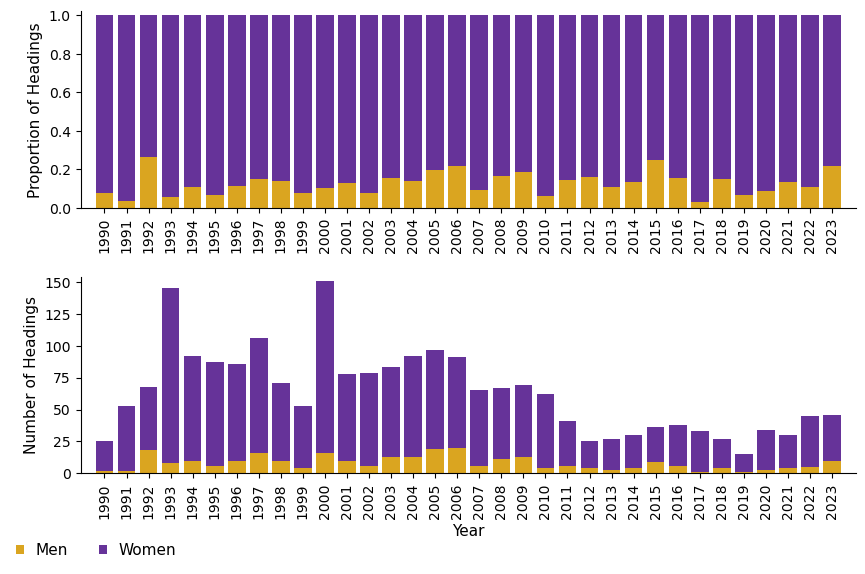

In [9]:
plots.added_each_year(1990, 2023, lcsh_m, lcsh_w, 'Headings')


The LCSH has also not changed since the 90s if you look at the asymmetry and markedness at different time points. 

In [10]:
dates = [1994, 2004, 2014, 2024]
diachronic_asymmetry, diachronic_markedness = gm.bias_across_time(dates, categories)
table5 = tt.Texttable()
table5.set_deco(tt.Texttable.HEADER)
table5.set_cols_align(['l', 'l', 'l', 'l', 'l'])
rows = [['', '% W', 'Total', '% W', 'Total']]
for i in range(len(dates)):
    total_asym = diachronic_asymmetry[i][0] + diachronic_asymmetry[i][1]
    w_percent_asym = diachronic_asymmetry[i][0]/total_asym

    total_marked = diachronic_markedness[i][0] + diachronic_markedness[i][1]
    w_percent_marked = diachronic_markedness[i][0]/total_marked
    row = [dates[i], f'{w_percent_asym:.2%}', total_asym, f'{w_percent_marked:.2%}', total_marked]
    rows.append(row)
table5.add_rows(rows)
print('')
caption = 'Asymmetry over time'
label = 'tab:diachronic-asymmetry'
table = lt.draw_latex(table5, caption, label, use_booktabs=True, caption_above=True)
print(f'\t{'Asymmetry'}\t {'Markedness'}')
print(table5.draw())


	Asymmetry	 Markedness
        % W     Total    % W     Total
1994   92.14%   967     95.77%   567  
2004   93.13%   1731    95.53%   1185 
2014   92.87%   2201    95.13%   1559 
2024   92.61%   2476    94.97%   1748 


## Syntactic Ngram

### Load Data (2008)

In [ ]:
df = pd.read_csv('Data/Syntactic Ngram/nouns_modified_by_gender.csv', sep='\t')

In [11]:
def get_gendered_ngrams(gram_list):
    m_grams = [gram for gram in gram_list if '<M>' in gram]
    w_grams = [gram for gram in gram_list if '<W>' in gram]
    return m_grams, w_grams

In [12]:
over_5 = df[df['FREQ'] >= 5]['PHRASE'].values
over_10 = df[df['FREQ'] >= 10]['PHRASE'].values
over_25 = df[df['FREQ'] >= 25]['PHRASE'].values
over_50 = df[df['FREQ'] >= 50]['PHRASE'].values
over_75 = df[df['FREQ'] >= 75]['PHRASE'].values
over_100 = df[df['FREQ'] >= 100]['PHRASE'].values
over_250 = df[df['FREQ'] >= 250]['PHRASE'].values
over_500 = df[df['FREQ'] >= 500]['PHRASE'].values
over_750 = df[df['FREQ'] >= 750]['PHRASE'].values
over_1000 = df[df['FREQ'] >= 1000]['PHRASE'].values

['58%', '50%', '45%', '42%', '45%', '50%', '52%', '58%', '63%', '74%']


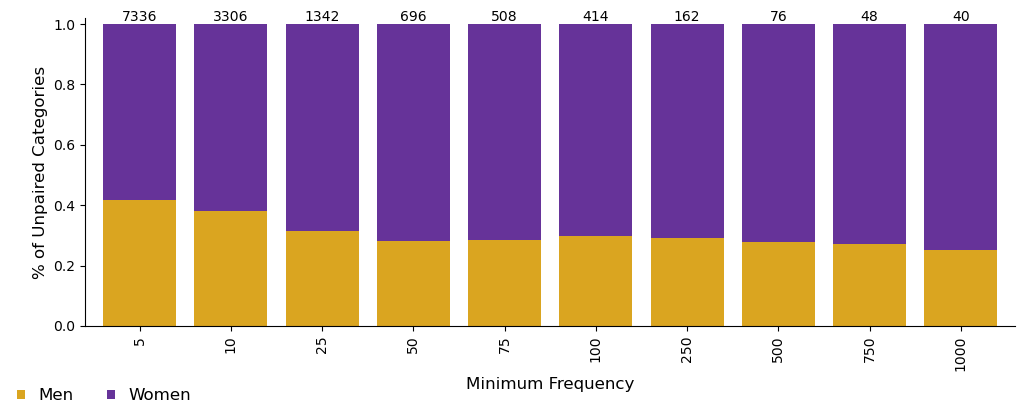

In [13]:
w_props = []
m_props = []
total_counts = []
percent_unbalanced = []
for gram_list in [over_5, over_10, over_25, over_50, over_75, over_100, over_250, over_500, over_750, over_1000]:  
    m_grams, w_grams = get_gendered_ngrams(gram_list)
    no_M = {re.sub(r'<M>', '', gram):gram for gram in m_grams}
    no_W = {re.sub(r'<W>', '', gram):gram for gram in w_grams}
    m_unablanced = [(no_M[k], None) for k in set(no_M.keys()) - set(no_W.keys())]
    w_unbalanced = [(None, no_W[k]) for k in set(no_W.keys()) - set(no_M.keys())]
    wm = [(no_M[k], no_W[k]) for k in set(no_M.keys()) & set(no_W.keys())]
    total_unbalanced = len(m_unablanced) + len(w_unbalanced)
    total_counts.append(total_unbalanced)
    w_props.append(len(w_unbalanced)/total_unbalanced)
    m_props.append(len(m_unablanced)/total_unbalanced)
    percent_unbalanced.append(f'{total_unbalanced/len(gram_list):.0%}')

counts = {'Men': m_props, 'Women': w_props}
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
x = ['5', '10', '25', '50', '75', '100', '250', '500', '750', '1000']
plotStacked(ax, x, counts, ['goldenrod', 'rebeccapurple'], xLabel='Minimum Frequency', yLabel='% of Unpaired Categories', barLabels=total_counts)



print(percent_unbalanced)

In [14]:
df = pd.read_csv('Data/Syntactic Ngram/modified_mw.csv', sep='\t')
over_5 = df[df['FREQ'] >= 5]['PHRASE'].values
over_10 = df[df['FREQ'] >= 10]['PHRASE'].values
over_25 = df[df['FREQ'] >= 25]['PHRASE'].values
over_50 = df[df['FREQ'] >= 50]['PHRASE'].values
over_75 = df[df['FREQ'] >= 75]['PHRASE'].values
over_100 = df[df['FREQ'] >= 100]['PHRASE'].values
over_250 = df[df['FREQ'] >= 250]['PHRASE'].values
over_500 = df[df['FREQ'] >= 500]['PHRASE'].values
over_750 = df[df['FREQ'] >= 750]['PHRASE'].values
over_1000 = df[df['FREQ'] >= 1000]['PHRASE'].values

## Wikipedia

## TO DO
1. Figure out what's going on with syntactic Ngram: come up with a set of cases that describe when mentioning men occurs more frequently than mentioning women and vice vera 
2. Finish wrangling my own set of Wikipedia data to preform same analyses as LCSH
3. Look at syntactic Ngram across time 